In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [46]:
data = pd.read_csv(r"D:\Desktop/gmail-api-automation/artifacts/for_training.csv")

In [47]:
data.head(3)

,id,from,subject,date,snippet,text,label
0,19407f49089741f0,Quora Digest <english-quora-digest@quora.com>,"If CTC is 9.5 LPA, then how much is the in-han...",2024-12-27 11:50:55+00:00,"Greetings, It can vary for different companies...","quora.com If CTC is 9.5 LPA, then how much is ...",INFORMATION
1,194b3420600fb28b,Product Hunt Daily <hello@digest.producthunt.com>,😸 And the award goes to...,2025-01-29 18:10:36+00:00,Announcing the 2024 Golden Kitty Award winners...,digest.producthunt.com 😸 And the award goes to...,PROMOTION
2,1924ea6d3edc5249,Kaggle <noreply@kaggle.com>,📅 [Invitation] Google Cloud App Dev & Infrastr...,2024-10-02 19:13:28+00:00,"Hi Varun reddy Amaravadhi, We&#39;re going to ...",kaggle.com 📅 [Invitation] Google Cloud App Dev...,PROMOTION


In [48]:
data['label'].value_counts()

label
PROMOTION      1787
INFORMATION    1051
OFFICIAL        715
TRASH           206
IMPORTANT        41
Name: count, dtype: int64

In [49]:
df=data[['text','label']]
df.head(3)

,text,label
0,"quora.com If CTC is 9.5 LPA, then how much is ...",INFORMATION
1,digest.producthunt.com 😸 And the award goes to...,PROMOTION
2,kaggle.com 📅 [Invitation] Google Cloud App Dev...,PROMOTION


In [50]:
df.shape

(3800, 2)

In [51]:
df['label'].unique()

<StringArray>
['INFORMATION', 'PROMOTION', 'OFFICIAL', 'TRASH', 'IMPORTANT']
Length: 5, dtype: str

In [52]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [53]:
df['label'].value_counts()

label
PROMOTION      1787
INFORMATION    1051
OFFICIAL        715
TRASH           206
IMPORTANT        41
Name: count, dtype: int64

In [54]:
X_text = df['text']
y = df['label']

## train test split

In [55]:
from sklearn.model_selection import train_test_split

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text,
    y,
    test_size=0.30,
    random_state=42,
    stratify=y
)


In [56]:
X_test_text.head()

846     linkedin.com The Maximum Virtual Product: An A...
2210    Donald Trump says foreigners who get a college...
2268    😸 Apple's PS5 competitor Everyone is raving ab...
2874    Don’t miss conversations in Data Science Commu...
662     lalal.ai Last Call: Spring Sale Is Ending — Sa...
Name: text, dtype: str

In [57]:
X_train_text.head()

2373    😸 Less terrible shopping Less terrible shoppin...
1536    mailer.ajio.in Is your winter wardrobe ready f...
1313    e.newyorktimes.com Offer alert: Sale ends tomo...
271     mail.beehiiv.com Conquer the Technical Intervi...
1622    e.newyorktimes.com Sale is on. Savings are her...
Name: text, dtype: str

In [58]:
y_train.head()

2373      PROMOTION
1536      PROMOTION
1313      PROMOTION
271     INFORMATION
1622      PROMOTION
Name: label, dtype: str

## pre-processing and cleaning

In [59]:
import re
#import nltk
#from nltk.corpus import stoprwords
from bs4 import BeautifulSoup

# TEXT CLEANING FUNCTION (EMAIL / NLP SAFE)
def clean_text(text):
    text = str(text)

    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove HTML tags only if present
    if '<' in text and '>' in text:
        text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Keep only letters and spaces
    text = re.sub(r'[^a-z\s]', ' ', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# APPLY ONCE
X_train_text = X_train_text.apply(clean_text)
X_test_text = X_test_text.apply(clean_text)



In [60]:
from sklearn.preprocessing import LabelEncoder
import joblib

le = LabelEncoder()
y_train = le.fit_transform(y_train)

# Transform test labels (NO FIT)
y_test = le.transform(y_test)

# Save encoder
joblib.dump(le, "data/label_encoder.pkl")

['data/label_encoder.pkl']

In [61]:
import pandas as pd

counts_y_train = pd.Series(y_train).value_counts().sort_values()
print(counts_y_train)
print(f"total records used in training: {sum(counts_y_train)}")
counts_y_test = pd.Series(y_test).value_counts().sort_values()
print(counts_y_test)
print(f"total records used in training: {sum(counts_y_test)}")



0      29
4     144
2     500
1     736
3    1251
Name: count, dtype: int64
total records used in training: 2660
0     12
4     62
2    215
1    315
3    536
Name: count, dtype: int64
total records used in training: 1140


In [62]:
print(X_train_text.shape)
print(X_test_text.shape)
print(y_test.shape)
print(y_train.shape)

(2660,)
(1140,)
(1140,)
(2660,)


In [63]:
# 4. TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

"""vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.85,
    sublinear_tf=True,
    max_features=8000,
    
)"""
vectorizer = TfidfVectorizer(
    max_features=30000,   # LIMIT THIS
    ngram_range=(1,2),
    sublinear_tf=True,
    min_df=2,
    max_df=0.95
)


In [64]:
X_train = vectorizer.fit_transform(X_train_text)
X_test  = vectorizer.transform(X_test_text)

In [65]:
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_train.shape)

(2660, 11590)
(1140, 11590)
(1140,)
(2660,)


In [66]:
print(len(vectorizer.vocabulary_))


11590


In [67]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)

weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

# Round to 2 decimal places
class_weight = {
    cls: round(weight, 2)
    for cls, weight in zip(classes, weights)
}

print(class_weight)


{np.int64(0): np.float64(18.34), np.int64(1): np.float64(0.72), np.int64(2): np.float64(1.06), np.int64(3): np.float64(0.43), np.int64(4): np.float64(3.69)}


In [68]:
class_weight = {
    0: 10.0,   # IMPORTANT - 44
    1: 0.76,   # INFORMATION - 413
    2: 1.28,   # OFFICIAL - 246
    3: 0.41,   # PROMOTION  - 758
    4: 2.83    # TRASH - 111
}


'''
0     44
4    111
2    246
1    413
3    758

{0: 10.0,
 1: 0.9,
2: 1.4, 3: 0.45, 4: 2.2}
{
  0: 7.0,
  1: 0.9,
  2: 1.4,
  3: 0.5,
  4: 3.2
}


class_weight = {
    0: 6.5,   # IMPORTANT - 51
    1: 2.5,   # INFORMATION - 451
    2: 4.0,   # OFFICIAL - 269
    3: 1.0,   # PROMOTION  - 908
    4: 2.0    # TRASH - 121
}


0     51
4    121
2    269
1    451
3    908

label
PROMOTION      908
INFORMATION    451
OFFICIAL       269
TRASH          121
IMPORTANT       51

}'''

'\n0     44\n4    111\n2    246\n1    413\n3    758\n\n{0: 10.0,\n 1: 0.9,\n2: 1.4, 3: 0.45, 4: 2.2}\n{\n  0: 7.0,\n  1: 0.9,\n  2: 1.4,\n  3: 0.5,\n  4: 3.2\n}\n\n\nclass_weight = {\n    0: 6.5,   # IMPORTANT - 51\n    1: 2.5,   # INFORMATION - 451\n    2: 4.0,   # OFFICIAL - 269\n    3: 1.0,   # PROMOTION  - 908\n    4: 2.0    # TRASH - 121\n}\n\n\n0     51\n4    121\n2    269\n1    451\n3    908\n\nlabel\nPROMOTION      908\nINFORMATION    451\nOFFICIAL       269\nTRASH          121\nIMPORTANT       51\n\n}'

In [69]:
# 5. Model
from sklearn.linear_model import LogisticRegression

Logistic_model = LogisticRegression(
    max_iter=2000,
    class_weight=class_weight,
    C=0.3,
    n_jobs=1              # IMPORTANT
)


Logistic_model.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",0.3
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*","{0: 10.0, 1: 0.76, 2: 1.28, 3: 0.41, ...}"
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a 

### prediction

In [70]:
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score, classification_report

y_pred = Logistic_model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("classification report: \n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[  9   2   0   0   1]
 [  0 293   1  20   1]
 [  0   3 207   5   0]
 [  0  29  11 494   2]
 [  0   0   0   1  61]]
Accuracy: 0.9333333333333333
classification report: 
               precision    recall  f1-score   support

           0       1.00      0.75      0.86        12
           1       0.90      0.93      0.91       315
           2       0.95      0.96      0.95       215
           3       0.95      0.92      0.94       536
           4       0.94      0.98      0.96        62

    accuracy                           0.93      1140
   macro avg       0.95      0.91      0.92      1140
weighted avg       0.93      0.93      0.93      1140



In [71]:
y_pred[:5]

array([2, 1, 3, 2, 3])

In [72]:
y_test[:5]

array([2, 1, 3, 2, 3])

In [73]:
print(le.classes_)

['IMPORTANT' 'INFORMATION' 'OFFICIAL' 'PROMOTION' 'TRASH']


In [74]:
"""import pandas as pd

test = pd.read_csv('D:/Desktop/gmail-api-automation/artifacts/test.csv')

# If column name is 'label'
if "label" in test.columns:
    test = test.drop(columns=["label"])

test.to_csv('D:/Desktop/gmail-api-automation/artifacts/test.csv', index=False)
"""

'import pandas as pd\n\ntest = pd.read_csv(\'D:/Desktop/gmail-api-automation/artifacts/test.csv\')\n\n# If column name is \'label\'\nif "label" in test.columns:\n    test = test.drop(columns=["label"])\n\ntest.to_csv(\'D:/Desktop/gmail-api-automation/artifacts/test.csv\', index=False)\n'

In [75]:
# ORIGINAL test dataframe (must contain text + label)
test_df = pd.read_csv('D:/Desktop/gmail-api-automation/artifacts/test.csv')

test_x_test = test_df["text"]



In [76]:
test_x_test = test_x_test.apply(clean_text)


In [77]:
test_x_test  = vectorizer.transform(test_x_test)

In [78]:
test_df['label'] = Logistic_model.predict(test_x_test)

"""error_df = test_df.copy()
error_df["y_true"] = y_test
error_df["y_pred"] = y_pred"""


'error_df = test_df.copy()\nerror_df["y_true"] = y_test\nerror_df["y_pred"] = y_pred'

In [79]:
test_df['label'].head()

0    2
1    3
2    3
3    1
4    3
Name: label, dtype: int64

In [80]:
test_df['label'] = le.inverse_transform(test_df['label'])


In [81]:
test_df.to_csv("test_for_eval_text.csv", index=False)

In [82]:
test_df.head(5)

,text,label
0,HPCL Junior Executive 2025 Job Notification HP...,OFFICIAL
1,hume.ai Welcome to Hume AI! 1. The Empathic AI...,PROMOTION
2,Learn and Play Chess with ChessKid 😎 Join the ...,PROMOTION
3,How was your interview experience at IIM Luckn...,INFORMATION
4,Never Have I Ever… Won ₹100 to spill the tea! ...,PROMOTION


In [83]:
#error_df[error_df['y_pred']!=error_df['y_true']]

In [84]:
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score, classification_report

y_pred_train = Logistic_model.predict(X_train)

print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_train))
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("classification report: \n", classification_report(y_train, y_pred_train))

Confusion Matrix:
 [[  29    0    0    0    0]
 [   1  686    7   40    2]
 [   1    1  495    3    0]
 [   5   48   13 1172   13]
 [   0    3    1    9  131]]
Accuracy: 0.9447368421052632
classification report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.89        29
           1       0.93      0.93      0.93       736
           2       0.96      0.99      0.97       500
           3       0.96      0.94      0.95      1251
           4       0.90      0.91      0.90       144

    accuracy                           0.94      2660
   macro avg       0.91      0.95      0.93      2660
weighted avg       0.95      0.94      0.94      2660



In [85]:
print("y_test:", len(y_test))
print("y_pred:", len(y_pred))


y_test: 1140
y_pred: 1140


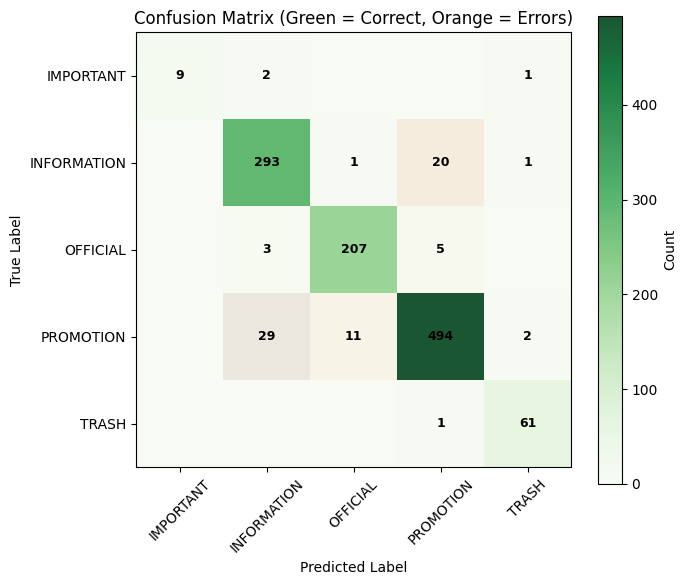

In [86]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

class_names = ["IMPORTANT", "INFORMATION", "OFFICIAL", "PROMOTION", "TRASH"]
n_classes = len(class_names)

plt.figure(figsize=(7, 6))

# masks
correct_mask = np.eye(n_classes)
error_mask = 1 - correct_mask

# plot errors first (orange)
plt.imshow(cm * error_mask, cmap="Oranges", alpha=0.9)

# overlay correct predictions (blue)
plt.imshow(cm * correct_mask, cmap="Greens", alpha=0.9)

plt.title("Confusion Matrix (Green = Correct, Orange = Errors)")
plt.colorbar(label="Count")

ticks = np.arange(n_classes)
plt.xticks(ticks, class_names, rotation=45)
plt.yticks(ticks, class_names)

# annotate
for i in range(n_classes):
    for j in range(n_classes):
        if cm[i, j] > 0:
            plt.text(
                j, i, cm[i, j],
                ha="center",
                va="center",
                color="black",
                fontsize=9,
                fontweight="bold"
            )

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


In [87]:
"""Confusion Matrix:
 [[  8   0   0   1   1]
 [  1  65   0  23   1]
 [  0   0  51   3   0]
 [  0  12   7 162   1]
 [  0   1   0   7  16]]
Accuracy: 0.8388888888888889
classification report: 
               precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.83      0.72      0.77        90
           2       0.88      0.94      0.91        54
           3       0.83      0.89      0.86       182
           4       0.84      0.67      0.74        24

    accuracy                           0.84       360
   macro avg       0.85      0.80      0.83       360
weighted avg       0.84      0.84      0.84       360"""

'Confusion Matrix:\n [[  8   0   0   1   1]\n [  1  65   0  23   1]\n [  0   0  51   3   0]\n [  0  12   7 162   1]\n [  0   1   0   7  16]]\nAccuracy: 0.8388888888888889\nclassification report: \n               precision    recall  f1-score   support\n\n           0       0.89      0.80      0.84        10\n           1       0.83      0.72      0.77        90\n           2       0.88      0.94      0.91        54\n           3       0.83      0.89      0.86       182\n           4       0.84      0.67      0.74        24\n\n    accuracy                           0.84       360\n   macro avg       0.85      0.80      0.83       360\nweighted avg       0.84      0.84      0.84       360'

In [88]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(
    loss="hinge",        # SVM
    alpha=0.0001,
    class_weight='balanced',
    max_iter=1000
)

sgd.fit(X_train, y_train)

,"loss loss: {'hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'}, default='hinge'The loss function to be used.- 'hinge' gives a linear SVM.- 'log_loss' gives logistic regression, a probabilistic classifier.- 'modified_huber' is another smooth loss that brings tolerance to outliers as well as probability estimates.- 'squared_hinge' is like hinge but is quadratically penalized.- 'perceptron' is the linear loss used by the perceptron algorithm.- The other losses, 'squared_error', 'huber', 'epsilon_insensitive' and 'squared_epsilon_insensitive' are designed for regression but can be useful in classification as well; see :class:`~sklearn.linear_model.SGDRegressor` for a description.More details about the losses formulas can be found in the :ref:`User Guide` and you can find a visualisation of the lossfunctions in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_loss_functions.py`.",'hinge'
,"penalty penalty: {'l2', 'l1', 'elasticnet', None}, default='l2'The penalty (aka regularization term) to be used. Defaults to 'l2'which is the standard regularizer for linear SVM models. 'l1' and'elasticnet' might bring sparsity to the model (feature selection)not achievable with 'l2'. No penalty is added when set to `None`.You can see a visualisation of the penalties in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_penalties.py`.",'l2'
,"alpha alpha: float, default=0.0001Constant that multiplies the regularization term. The higher thevalue, the stronger the regularization. Also used to compute thelearning rate when `learning_rate` is set to 'optimal'.Values must be in the range `[0.0, inf)`.",0.0001
,"l1_ratio l1_ratio: float, default=0.15The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1.l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1.Only used if `penalty` is 'elasticnet'.Values must be in the range `[0.0, 1.0]` or can be `None` if`penalty` is not `elasticnet`... versionchanged:: 1.7 `l1_ratio` can be `None` when `penalty` is not ""elasticnet"".",0.15
,"fit_intercept fit_intercept: bool, default=TrueWhether the intercept should be estimated or not. If False, thedata is assumed to be already centered.",True
,"max_iter max_iter: int, default=1000The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the ``fit`` method, and not the:meth:`partial_fit` method.Values must be in the range `[1, inf)`... versionadded:: 0.19",1000
,"tol tol: float or None, default=1e-3The stopping criterion. If it is not None, training will stopwhen (loss > best_loss - tol) for ``n_iter_no_change`` consecutiveepochs.Convergence is checked against the training loss or thevalidation loss depending on the `early_stopping` parameter.Values must be in the range `[0.0, inf)`... versionadded:: 0.19",0.001
,"shuffle shuffle: bool, default=TrueWhether or not the training data should be shuffled after each epoch.",True
,"verbose verbose: int, default=0The verbosity level.Values must be in the range `[0, inf)`.",0
,"epsilon epsilon: float, default=0.1Epsilon in the epsilon-insensitive loss functions; only if `loss` is'huber', 'epsilon_insensitive', or 'squared_epsilon_insensitive'.For 'huber', determines the threshold at which it becomes lessimportant to get the prediction exactly right.For epsilon-insensitive, any differences between the current predictionand the correct label are ignored if they are less than this threshold.Values must be in the range `[0.0, inf)`.",0.1
,"n_jobs n_jobs: int, default=NoneThe number of CPUs to use to do the OVA (One Versus All, formulti-class problems) computation.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


In [89]:
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score, classification_report

y_pred_sgd = sgd.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_sgd))
print("Accuracy:", accuracy_score(y_test, y_pred_sgd))
print("classification report: \n", classification_report(y_test, y_pred_sgd))

Confusion Matrix:
 [[  8   2   0   2   0]
 [  0 280   1  32   2]
 [  0   3 208   4   0]
 [  0  36  11 486   3]
 [  0   0   0   2  60]]
Accuracy: 0.9140350877192982
classification report: 
               precision    recall  f1-score   support

           0       1.00      0.67      0.80        12
           1       0.87      0.89      0.88       315
           2       0.95      0.97      0.96       215
           3       0.92      0.91      0.92       536
           4       0.92      0.97      0.94        62

    accuracy                           0.91      1140
   macro avg       0.93      0.88      0.90      1140
weighted avg       0.91      0.91      0.91      1140



In [90]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB(alpha=1.0)

nb.fit(X_train, y_train)



,"alpha alpha: float or array-like of shape (n_features,), default=1.0Additive (Laplace/Lidstone) smoothing parameter(set alpha=0 and force_alpha=True, for no smoothing).",1.0
,"force_alpha force_alpha: bool, default=TrueIf False and alpha is less than 1e-10, it will set alpha to1e-10. If True, alpha will remain unchanged. This may causenumerical errors if alpha is too close to 0... versionadded:: 1.2.. versionchanged:: 1.4 The default value of `force_alpha` changed to `True`.",True
,"fit_prior fit_prior: bool, default=TrueWhether to learn class prior probabilities or not.If false, a uniform prior will be used.",True
,"class_prior class_prior: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None


In [91]:
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score, classification_report

y_pred_nb = nb.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("classification report: \n", classification_report(y_test, y_pred_nb))

Confusion Matrix:
 [[  2   3   2   5   0]
 [  0 264   1  49   1]
 [  0  13 186  16   0]
 [  0  19   9 508   0]
 [  0   1   0  20  41]]
Accuracy: 0.8780701754385964
classification report: 
               precision    recall  f1-score   support

           0       1.00      0.17      0.29        12
           1       0.88      0.84      0.86       315
           2       0.94      0.87      0.90       215
           3       0.85      0.95      0.90       536
           4       0.98      0.66      0.79        62

    accuracy                           0.88      1140
   macro avg       0.93      0.70      0.75      1140
weighted avg       0.88      0.88      0.87      1140



In [92]:
from sklearn.svm import LinearSVC
# C = [0.3, 1, 3]

clf = LinearSVC(class_weight="balanced", max_iter=2000, C = 2.5)
clf.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2'}, default='l2'Specifies the norm used in the penalization. The 'l2'penalty is the standard used in SVC. The 'l1' leads to ``coef_``vectors that are sparse.",'l2'
,"loss loss: {'hinge', 'squared_hinge'}, default='squared_hinge'Specifies the loss function. 'hinge' is the standard SVM loss(used e.g. by the SVC class) while 'squared_hinge' is thesquare of the hinge loss. The combination of ``penalty='l1'``and ``loss='hinge'`` is not supported.",'squared_hinge'
,"dual dual: ""auto"" or bool, default=""auto""Select the algorithm to either solve the dual or primaloptimization problem. Prefer dual=False when n_samples > n_features.`dual=""auto""` will choose the value of the parameter automatically,based on the values of `n_samples`, `n_features`, `loss`, `multi_class`and `penalty`. If `n_samples` < `n_features` and optimizer supportschosen `loss`, `multi_class` and `penalty`, then dual will be set to True,otherwise it will be set to False... versionchanged:: 1.3 The `""auto""` option is added in version 1.3 and will be the default in version 1.5.",'auto'
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive.For an intuitive visualization of the effects of scalingthe regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",2.5
,"multi_class multi_class: {'ovr', 'crammer_singer'}, default='ovr'Determines the multi-class strategy if `y` contains more thantwo classes.``""ovr""`` trains n_classes one-vs-rest classifiers, while``""crammer_singer""`` optimizes a joint objective over all classes.While `crammer_singer` is interesting from a theoretical perspectiveas it is consistent, it is seldom used in practice as it rarely leadsto better accuracy and is more expensive to compute.If ``""crammer_singer""`` is chosen, the options loss, penalty and dualwill be ignored.",'ovr'
,"fit_intercept fit_intercept: bool, default=TrueWhether or not to fit an intercept. If set to True, the feature vectoris extended to include an intercept term: `[x_1, ..., x_n, 1]`, where1 corresponds to the intercept. If set to False, no intercept will beused in calculations (i.e. data is expected to be already centered).",True
,"intercept_scaling intercept_scaling: float, default=1.0When `fit_intercept` is True, the instance vector x becomes ``[x_1,..., x_n, intercept_scaling]``, i.e. a ""synthetic"" feature with aconstant value equal to `intercept_scaling` is appended to the instancevector. The intercept becomes intercept_scaling * synthetic featureweight. Note that liblinear internally penalizes the intercept,treating it like any other term in the feature vector. To reduce theimpact of the regularization on the intercept, the `intercept_scaling`parameter can be set to a value greater than 1; the higher the value of`intercept_scaling`, the lower the impact of regularization on it.Then, the weights become `[w_x_1, ..., w_x_n,w_intercept*intercept_scaling]`, where `w_x_1, ..., w_x_n` representthe feature weights and the intercept weight is scaled by`intercept_scaling`. This scaling allows the intercept term to have adifferent regularization behavior compared to the other features.",1
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to ``class_weight[i]*C`` forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",'balanced'
,"verbose verbose: int, default=0Enable verbose output. Note that this setting takes advantage of aper-process runtime setting in liblinear that, if enabled, may not workproperly in a multithreaded context.",0
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseud

In [93]:
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score, classification_report

y_pred_clf = clf.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_clf))
print("Accuracy:", accuracy_score(y_test, y_pred_clf))
print("classification report: \n", classification_report(y_test, y_pred_clf))

Confusion Matrix:
 [[  7   2   0   3   0]
 [  0 281   1  32   1]
 [  0   3 208   4   0]
 [  0  34  11 487   4]
 [  0   0   0   2  60]]
Accuracy: 0.9149122807017543
classification report: 
               precision    recall  f1-score   support

           0       1.00      0.58      0.74        12
           1       0.88      0.89      0.89       315
           2       0.95      0.97      0.96       215
           3       0.92      0.91      0.92       536
           4       0.92      0.97      0.94        62

    accuracy                           0.91      1140
   macro avg       0.93      0.86      0.89      1140
weighted avg       0.92      0.91      0.91      1140



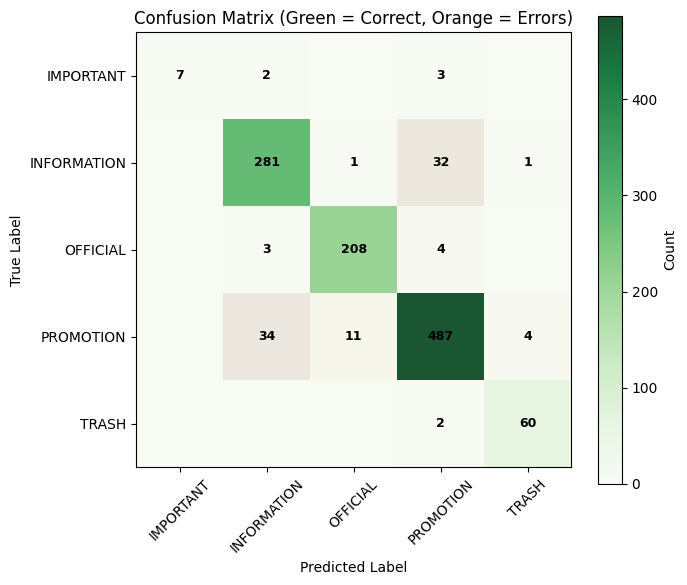

In [94]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_clf)

class_names = ["IMPORTANT", "INFORMATION", "OFFICIAL", "PROMOTION", "TRASH"]
n_classes = len(class_names)

plt.figure(figsize=(7, 6))

# masks
correct_mask = np.eye(n_classes)
error_mask = 1 - correct_mask

# plot errors first (orange)
plt.imshow(cm * error_mask, cmap="Oranges", alpha=0.9)

# overlay correct predictions (blue)
plt.imshow(cm * correct_mask, cmap="Greens", alpha=0.9)

plt.title("Confusion Matrix (Green = Correct, Orange = Errors)")
plt.colorbar(label="Count")

ticks = np.arange(n_classes)
plt.xticks(ticks, class_names, rotation=45)
plt.yticks(ticks, class_names)

# annotate
for i in range(n_classes):
    for j in range(n_classes):
        if cm[i, j] > 0:
            plt.text(
                j, i, cm[i, j],
                ha="center",
                va="center",
                color="black",
                fontsize=9,
                fontweight="bold"
            )

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


In [95]:
"""import joblib

joblib.dump(clf, "email_classifier.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")
"""

'import joblib\n\njoblib.dump(clf, "email_classifier.pkl")\njoblib.dump(vectorizer, "vectorizer.pkl")\n'